In [16]:
#Solution adapted from Kris C Naik
#GitHub https://github.com/krishnaik06/Stock-Price-Prediction-using-Keras-and-Recurrent-Neural-Networ/blob/master/rnn.py
import matplotlib.pyplot as plt
import pandas as pd
import datetime as dt
import urllib.request, json
import pickle
import os
import numpy as np
import tensorflow as tf # This code has been tested with TensorFlow 1.6
from sklearn.preprocessing import MinMaxScaler
from pandas.plotting import autocorrelation_plot
#from app.model.preprocessor import Preprocessor as img_prep #image preprocessing




ModuleNotFoundError: No module named 'app.model'

In [12]:
import pandas_datareader as dr
from datetime import datetime
import pandas_datareader.data as web

In [13]:
start=datetime(2015,1,1)
end=datetime(2019,4,1)

In [14]:
# tesla = web.DataReader('TSLA', 'google', start,end)
microsoft = dr.data.get_data_yahoo('MSFT', start=start, end=end)

dataset = microsoft
dataset.head()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2015-01-02,47.419998,46.540001,46.660000,46.759998,27913900.0,42.418739
2015-01-05,46.730000,46.250000,46.369999,46.330002,39673900.0,42.028660
2015-01-06,46.750000,45.540001,46.380001,45.650002,36447900.0,41.411785
2015-01-07,46.459999,45.490002,45.980000,46.230000,29114100.0,41.937946
2015-01-08,47.750000,46.720001,46.750000,47.590000,29645200.0,43.171677


In [21]:
#class for loading our saved model and classifying new images
class LiteOCR:
    def __init__(self, fn="alpha_weights.pkl", pool_size=2):
        #load the weights from the pickle file and the meta data
        [weights, meta] = pickle.load(open(fn, 'rb'), encoding='latin1') #currently, this class MUST be initialized from a pickle file
        #list to store labels
        self.vocab = meta["vocab"]
        
        #how many rows and columns in an image
        self.img_rows = meta["img_side"] ; self.img_cols = meta["img_side"]
        
        #load our CNN
        self.CNN = LiteCNN()
        #with our saved weights
        self.CNN.load_weights(weights)
        #define the pooling layers size
        self.CNN.pool_size=int(pool_size)
    
    #classify new image
    def predict(self, image):
        print(image.shape)
        #vectorize the image into the right shape for our network
        X = np.reshape(image, (1, 1, self.img_rows, self.img_cols))
        X = X.astype("float32")
        
        #make the prediction
        predicted_i = self.CNN.predict(X)
        #return the predicted label
        return self.vocab[predicted_i]

In [32]:
class LiteCNN:
    def __init__(self):
        sel.layers=[]
        #size of pooling area for max pooling
        self.pool_size=None

    def load_weight(self, weights):
        assert not self.layers, "Weights can only be loaded once!"
        #add the saved matrix values to the convolutional network
        for k in range(len(weights.keys())):
            self.layers.append(weights['layer{}'.format(k)])
    def predict(self, X):
        #here is where the network magic happens at a high level
        h=self.cnn_layer(Xm, layer_i=0,border_mode='full'); X=h
        h = self.relu_layer(X); X=h;
        h = self.cnn_layer(X, layer_i=2, border_mode='valid'); X=h
        h = self.relu_layer(X); X=h;
        h = self.maxpooling_layer(X); x=h;
        h = self.dropout_layer(X, .25); x=h;
        h = self.flatten_layer(X, layer_i=7); X = h;
        h = self.dense_layer(X, fully, layer_i=0); X = h;
        h = self.softmax_layer2D(X); x = h;
        max_i = self.classify(X)
        return max_i[0]
    
#given our feature map we've learned from convolving around the image
    #lets make it more dense by performing pooling, specifically max pooling
    #we'll select the max values from the image matrix and use that as our new feature map
    def maxpooling_layer(self, convolved_features):
        #given our learned features and images
        nb_features = convolved_features.shape[0]
        nb_images = convolved_features.shape[1]
        conv_dim = convolved_features.shape[2]
        res_dim = int(conv_dim / self.pool_size)       #assumed square shape

        #initialize our more dense feature list as empty
        pooled_features = np.zeros((nb_features, nb_images, res_dim, res_dim))
        #for each image
        for image_i in range(nb_images):
            #and each feature map
            for feature_i in range(nb_features):
                #begin by the row
                for pool_row in range(res_dim):
                    #define start and end points
                    row_start = pool_row * self.pool_size
                    row_end   = row_start + self.pool_size

                    #for each column (so its a 2D iteration)
                    for pool_col in range(res_dim):
                        #define start and end points
                        col_start = pool_col * self.pool_size
                        col_end   = col_start + self.pool_size

                        #define a patch given our defined starting ending points
                        patch = convolved_features[feature_i, image_i, row_start : row_end,col_start : col_end]
                        #then take the max value from that patch
                        #store it. this is our new learned feature/filter
                        pooled_features[feature_i, image_i, pool_row, pool_col] = np.max(patch)
        return pooled_features

    #convolution is the most important of the matrix operations here
    #well define our input, lauyer number, and a border mode (explained below)
    def cnn_layer(self, X, layer_i=0, border_mode = "full"):
        #we'll store our feature maps and bias value in these 2 vars
        features = self.layers[layer_i]["param_0"]
        bias = self.layers[layer_i]["param_1"]
        #how big is our filter/patch?
        patch_dim = features[0].shape[-1]
        #how many features do we have?
        nb_features = features.shape[0]
        #How big is our image?
        image_dim = X.shape[2] #assume image square
        #R G B values
        image_channels = X.shape[1]
        #how many images do we have?
        nb_images = X.shape[0]

        #With border mode "full" you get an output that is the "full" size as the input. 
        #That means that the filter has to go outside the bounds of the input by "filter size / 2" - 
        #the area outside of the input is normally padded with zeros.
        if border_mode == "full":
            conv_dim = image_dim + patch_dim - 1
        #With border mode "valid" you get an output that is smaller than the input because 
        #the convolution is only computed where the input and the filter fully overlap.
        elif border_mode == "valid":
            conv_dim = image_dim - patch_dim + 1

        #we'll initialize our feature matrix
        convolved_features = np.zeros((nb_images, nb_features, conv_dim, conv_dim));
        #then we'll iterate through each image that we have
        for image_i in range(nb_images):
            #for each feature 
            for feature_i in range(nb_features):
                #lets initialize a convolved image as empty
                convolved_image = np.zeros((conv_dim, conv_dim))
                #then for each channel (r g b )
                for channel in range(image_channels):
                    #lets extract a feature from our feature map
                    feature = features[feature_i, channel, :, :]
                    #then define a channel specific part of our image
                    image   = X[image_i, channel, :, :]
                    #perform convolution on our image, using a given feature filter
                    convolved_image += self.convolve2d(image, feature, border_mode);

                #add a bias to our convoved image
                convolved_image = convolved_image + bias[feature_i]
                #add it to our list of convolved features (learnings)
                convolved_features[image_i, feature_i, :, :] = convolved_image
        return convolved_features

    #In a dense layer, every node in the layer is connected to every node in the preceding layer.
    def dense_layer(self, X, layer_i=0):
        #so we'll initialize our weight and bias for this layer
        W = self.layers[layer_i]["param_0"]
        b = self.layers[layer_i]["param_1"]
        #and multiply it by our input (dot product)
        output = np.dot(X, W) + b
        return output

    @staticmethod

    #so what does the convolution operation look like?, given an image and a feature map (filter)
    def convolve2d(image, feature, border_mode="full"):
        #we'll define the tensor dimensions of the image and the feature
        image_dim = np.array(image.shape)
        feature_dim = np.array(feature.shape)
        #as well as a target dimension
        target_dim = image_dim + feature_dim - 1
        #then we'll perform a fast fourier transform on both the input and the filter
        #performing a convolution can be written as a for loop but for many convolutions
        #this approach is too comp. expensive/slow. it can be performed orders of magnitude
        #faster using a fast fourier transform. 
        fft_result = np.fft.fft2(image, target_dim) * np.fft.fft2(feature, target_dim)
        #and set the result to our target 
        target = np.fft.ifft2(fft_result).real

        if border_mode == "valid":
            # To compute a valid shape, either np.all(x_shape >= y_shape) or
            # np.all(y_shape >= x_shape).
            #decide a target dimension to convolve around
            valid_dim = image_dim - feature_dim + 1
            if np.any(valid_dim < 1):
                valid_dim = feature_dim - image_dim + 1
            start_i = (target_dim - valid_dim) // 2
            end_i = start_i + valid_dim
            target = target[start_i[0]:end_i[0], start_i[1]:end_i[1]]
        return target

    def relu_layer(x):
        #turn all negative values in a matrix into zeros
        z = np.zeros_like(x)
        return np.where(x>z,x,z)

    def softmax_layer2D(w):
        #this function will calculate the probabilities of each
        #target class over all possible target classes. 
        maxes = np.amax(w, axis=1)
        maxes = maxes.reshape(maxes.shape[0], 1)
        e = np.exp(w - maxes)
        dist = e / np.sum(e, axis=1, keepdims=True)
        return dist

    #affect the probability a node will be turned off by multiplying it
    #by a p values (.25 we define)
    def dropout_layer(X, p):
        retain_prob = 1. - p
        X *= retain_prob
        return X

    #get the largest probabililty value from the list
    def classify(X):
        return X.argmax(axis=-1)

    #tensor transformation, less dimensions
    def flatten_layer(X):
        flatX = np.zeros((X.shape[0],np.prod(X.shape[1:])))
        for i in range(X.shape[0]):
            flatX[i,:] = X[i].flatten(order='C')
        return flatX

In [33]:
 # First calculate the mid prices from the highest and lowest

train_data = model_dataset[:750]
test_data = model_dataset[750:]

print(train_data.transpose())
print(len(test_data))

[[46.65999985 46.36999893 46.38000107 45.97999954 46.75       47.61000061
  47.41999817 46.97000122 45.95999908 46.22000122 45.31000137 46.29999924
  45.93999863 46.38000107 47.36000061 47.         42.95000076 42.74000168
  40.93000031 41.54999924 40.59000015 41.63000107 41.93999863 42.22000122
  42.68000031 42.24000168 42.74000168 42.65000153 42.65999985 43.38000107
  43.97000122 43.63000107 43.18000031 43.50999832 43.70000076 44.15000153
  43.95000076 43.99000168 44.13000107 43.66999817 43.56000137 43.00999832
  43.06999969 43.         42.18999863 42.34999847 42.31000137 41.33000183
  40.70000076 41.47000122 41.36999893 41.43000031 42.25999832 42.56000137
  42.88000107 42.77999878 42.91999817 41.22000122 41.11999893 41.09999847
  40.77999878 40.59999847 40.65999985 40.34000015 41.61000061 41.45999908
  41.25       41.63000107 41.40000153 41.79999924 41.75999832 41.95000076
  41.66999817 41.72999954 43.         42.66999817 42.88999939 45.65999985
  47.22999954 47.77999878 48.72000122 

In [7]:
# Scale the data to be between 0 and 1
# When scaling remember! You normalize both test and train data with respect to training data
# Because you are not supposed to have access to test data
sc = MinMaxScaler(feature_range = (0, 1))
training_set_scaled = sc.fit_transform(train_data)

In [8]:
# Creating a data structure with 63 (approx. 1 quarter) timesteps and 1 output (next day value)
X_train = []
y_train = []
for i in range(63, len(training_set_scaled)):
    X_train.append(training_set_scaled[i-63:i, 0])
    y_train.append(training_set_scaled[i, 0])
X_train, y_train = np.array(X_train), np.array(y_train)

# Reshaping
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

print(X_train.shape[1])
print(len(y_train))

63
687


In [9]:
# Part 2 - Building the RNN

# Importing the Keras libraries and packages
#https://keras.io/layer/recurrent
from keras.models import Sequential
from keras.layers import Dense #output layer
from keras.layers import LSTM
from keras.layers import Dropout #for each Epox deactivate those that result in 0

Using TensorFlow backend.


In [10]:
# Initialising the RNN
regressor = Sequential()

In [11]:
# Adding the first LSTM layer and some Dropout regularisation
regressor.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train.shape[1], 1)))
regressor.add(Dropout(0.2))

# Adding a second LSTM layer and some Dropout regularisation
regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.2))

# Adding a third LSTM layer and some Dropout regularisation
regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.2))

# Adding a fourth LSTM layer and some Dropout regularisation
regressor.add(LSTM(units = 50))
regressor.add(Dropout(0.2))

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Model, fit and plot data using regressor calculated above.

In [12]:
# Adding the output layer
regressor.add(Dense(units = 1))

# Compiling the RNN
regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')

# Fitting the RNN to the Training set
regressor.fit(X_train, y_train, epochs = 30, batch_size = 100)

Instructions for updating:
Use tf.cast instead.
Epoch 1/30
687/687 [==============================] - 5s 7ms/step - loss: 0.1045
Epoch 2/30
687/687 [==============================] - 2s 2ms/step - loss: 0.0296
Epoch 3/30
687/687 [==============================] - 2s 4ms/step - loss: 0.0186
Epoch 4/30
687/687 [==============================] - 2s 2ms/step - loss: 0.0112
Epoch 5/30
687/687 [==============================] - 2s 3ms/step - loss: 0.0069
Epoch 6/30
687/687 [==============================] - 2s 2ms/step - loss: 0.0048
Epoch 7/30
687/687 [==============================] - 2s 2ms/step - loss: 0.0045
Epoch 8/30
687/687 [==============================] - 2s 2ms/step - loss: 0.0045
Epoch 9/30
687/687 [==============================] - 2s 2ms/step - loss: 0.0039
Epoch 10/30
687/687 [==============================] - 2s 2ms/step - loss: 0.0043
Epoch 11/30
687/687 [==============================] - 2s 2ms/step - loss: 0.0040
Epoch 12/30
687/687 [==============================] - 2s 2

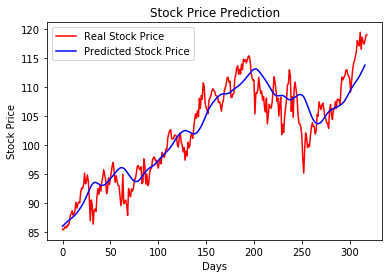

In [50]:
# Setting Real stock price
real_stock_price = test_data

# Getting the predicted stock price
dataset_total = dataset['Close']
inputs = dataset_total[len(dataset_total) - len(test_data) - 63:].values
inputs = inputs.reshape(-1,1)
inputs = sc.transform(inputs)
X_test = []
for i in range(63, 380):
    X_test.append(inputs[i-63:i, 0])
X_test = np.array(X_test)


X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
predicted_stock_price = regressor.predict(X_test)
predicted_stock_price = sc.inverse_transform(predicted_stock_price)

# Visualising the results

plt.plot(real_stock_price, color = 'red', label = 'Real Stock Price')
plt.plot(predicted_stock_price, color = 'blue', label = 'Predicted Stock Price')
plt.title('Stock Price Prediction')
plt.xlabel('Days')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

In [14]:
from pandas.tseries.offsets import DateOffset

In [15]:
future_dates = [dataset.index[-1] + DateOffset(days=x) for x in range(1,365)]

[Timestamp('2019-04-03 00:00:00'),
 Timestamp('2019-04-04 00:00:00'),
 Timestamp('2019-04-05 00:00:00'),
 Timestamp('2019-04-06 00:00:00'),
 Timestamp('2019-04-07 00:00:00'),
 Timestamp('2019-04-08 00:00:00'),
 Timestamp('2019-04-09 00:00:00'),
 Timestamp('2019-04-10 00:00:00'),
 Timestamp('2019-04-11 00:00:00'),
 Timestamp('2019-04-12 00:00:00'),
 Timestamp('2019-04-13 00:00:00'),
 Timestamp('2019-04-14 00:00:00'),
 Timestamp('2019-04-15 00:00:00'),
 Timestamp('2019-04-16 00:00:00'),
 Timestamp('2019-04-17 00:00:00'),
 Timestamp('2019-04-18 00:00:00'),
 Timestamp('2019-04-19 00:00:00'),
 Timestamp('2019-04-20 00:00:00'),
 Timestamp('2019-04-21 00:00:00'),
 Timestamp('2019-04-22 00:00:00'),
 Timestamp('2019-04-23 00:00:00'),
 Timestamp('2019-04-24 00:00:00'),
 Timestamp('2019-04-25 00:00:00'),
 Timestamp('2019-04-26 00:00:00'),
 Timestamp('2019-04-27 00:00:00'),
 Timestamp('2019-04-28 00:00:00'),
 Timestamp('2019-04-29 00:00:00'),
 Timestamp('2019-04-30 00:00:00'),
 Timestamp('2019-05-

In [43]:
print(regressor.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 63, 50)            10400     
_________________________________________________________________
dropout_1 (Dropout)          (None, 63, 50)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 63, 50)            20200     
_________________________________________________________________
dropout_2 (Dropout)          (None, 63, 50)            0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 63, 50)            20200     
_________________________________________________________________
dropout_3 (Dropout)          (None, 63, 50)            0         
_________________________________________________________________
lstm_4 (LSTM)                (None, 50)                20200     
__________

In [45]:
x = np.array(future_dates.index)

future_dates['forecast'] = regressor.predict(np.array(future_dates.index))

ValueError: Error when checking input: expected lstm_1_input to have 3 dimensions, but got array with shape ()